In [1]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

np.random.seed(42)

digits = load_digits()
data = scale(digits.data)

n_samples, n_features = data.shape
n_digits = len(np.unique(digits.target))
labels = digits.target

sample_size = 300

print("n_digits: %d, \t n_samples %d, \t n_features %d"
      % (n_digits, n_samples, n_features))


print(82 * '_')
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')


def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    predicoes = estimator.fit_predict(data)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))

bench_k_means(KMeans(init='k-means++', n_clusters=n_digits, n_init=10),
              name="k-means++", data=data)

bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=10),
              name="random", data=data)

# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
pca = PCA(n_components=n_digits).fit(data)
bench_k_means(KMeans(init=pca.components_, n_clusters=n_digits, n_init=1),
              name="PCA-based",
              data=data)
print(82 * '_')

# #############################################################################
# Visualize the results on PCA-reduced data

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()


n_digits: 10, 	 n_samples 1797, 	 n_features 64
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.92s	69661	0.670	0.709	0.689	0.557	0.667	0.129
random   	0.57s	69657	0.674	0.715	0.694	0.558	0.671	0.136
PCA-based	0.10s	70679	0.676	0.705	0.690	0.560	0.672	0.119
__________________________________________________________________________________


<Figure size 640x480 with 1 Axes>

### [Homogeneity Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html#sklearn.metrics.homogeneity_score)

Homogeneity metric of a cluster labeling given a ground truth.

A clustering result satisfies homogeneity if all of its clusters contain only data points which are members of a single class.

This metric is independent of the absolute values of the labels: a permutation of the class or cluster label values won’t change the score value in any way.

This metric is not symmetric: switching label_true with label_pred will return the completeness_score which will be different in general.

### [Completeness Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.completeness_score.html#sklearn.metrics.completeness_score)

Completeness metric of a cluster labeling given a ground truth.

A clustering result satisfies completeness if all the data points that are members of a given class are elements of the same cluster.

This metric is independent of the absolute values of the labels: a permutation of the class or cluster label values won’t change the score value in any way.

This metric is not symmetric: switching label_true with label_pred will return the homogeneity_score which will be different in general.

### [V-Measure Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.v_measure_score.html#sklearn.metrics.v_measure_score)

V-measure cluster labeling given a ground truth.

This score is identical to normalized_mutual_info_score with the 'arithmetic' option for averaging.

The V-measure is the harmonic mean between homogeneity and completeness:

$v = \frac{(1 + beta) * homogeneity * completeness}{beta * homogeneity + completeness}$

This metric is independent of the absolute values of the labels: a permutation of the class or cluster label values won’t change the score value in any way.

This metric is furthermore symmetric: switching label_true with label_pred will return the same score value. This can be useful to measure the agreement of two independent label assignments strategies on the same dataset when the real ground truth is not known.

### [Adjusted Rand Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html#sklearn.metrics.adjusted_rand_score)

Rand index adjusted for chance.

The Rand Index computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings.

The raw RI score is then “adjusted for chance” into the ARI score using the following scheme:

$ARI = \frac{RI - Expected_{RI}}{max(RI) - Expected_{RI}}$

The adjusted Rand index is thus ensured to have a value close to 0.0 for random labeling independently of the number of clusters and samples and exactly 1.0 when the clusterings are identical (up to a permutation).

ARI is a symmetric measure:

$adjusted\_rand\_score(a, b) == adjusted\_rand\_score(b, a)$

### [Adjusted Mutual Info Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_mutual_info_score.html#sklearn.metrics.adjusted_mutual_info_score)

Adjusted Mutual Information between two clusterings.

Adjusted Mutual Information (AMI) is an adjustment of the Mutual Information (MI) score to account for chance. It accounts for the fact that the MI is generally higher for two clusterings with a larger number of clusters, regardless of whether there is actually more information shared. For two clusterings  and , the AMI is given as:

$AMI(U, V) = \frac{MI(U, V) - E(MI(U, V))}{avg(H(U), H(V)) - E(MI(U, V))}$

This metric is independent of the absolute values of the labels: a permutation of the class or cluster label values won’t change the score value in any way.

This metric is furthermore symmetric: switching label_true with label_pred will return the same score value. This can be useful to measure the agreement of two independent label assignments strategies on the same dataset when the real ground truth is not known.

Be mindful that this function is an order of magnitude slower than other metrics, such as the Adjusted Rand Index.

### [Silhouette Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score)

Compute the mean Silhouette Coefficient of all samples.

The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b). To clarify, b is the distance between a sample and the nearest cluster that the sample is not a part of. Note that Silhouette Coefficient is only defined if number of labels is 2 <= n_labels <= n_samples - 1.

This function returns the mean Silhouette Coefficient over all samples. To obtain the values for each sample, use silhouette_samples.

The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.


# Exercício 1

### Homogeneity Score

Medida para indicar o quão homogeneos estão os _clusters_, ou seja, o quanto cada _cluster_ está "puro", apenas com elementos de uma mesma classe apenas.

Utilizando o PCA, a ideia é que tenhamos um espaço de amostras melhor espaçadas, facilitando a criação de _clusters_ mais homogêneos.

### Completeness Score

Medida para indicar o quão agrupado estão elementos de uma mesma classe em _clusters_ espefícico para cada uma das classes. 

> Essa medida não será interferida pela troca completa dos elementos entre dois _cluster_ ou pela troca dos _labels_ dos _clusters_.

Utilizando o PCA não necessariamente haverá uma melhora desse _score_, visto que esse "espalhamento" das amostras pode separar agrupamentos de elementos de um mesmo _label_.

### V-Measure Score

Média harmônica entre a _homogeneity score_ e _completeness score_.

### Adjusted Rand Score

Medida de similaridade entre dois agrupamentos realizados.

### Adjusted Mutual Info Score



### Silhouette Score

Busca avaliar quão apropriado é o mapeamento entre amostras e clusters.


# Exercício 2

> Visualizar e entender os dois notebook do **Leaf Dataset**


# Exercício 3

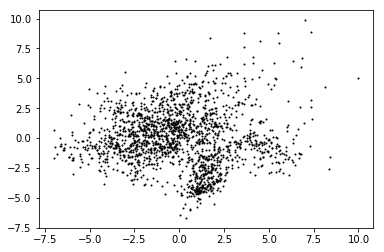

In [2]:
X = PCA(n_components=2).fit_transform(data)

plt.figure(2)
plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
plt.show()

In [3]:
Sum_of_squared_distances = []

K = range(1,30)

for k in K:
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
    kmeans.fit(X)
    Sum_of_squared_distances.append(kmeans.inertia_)

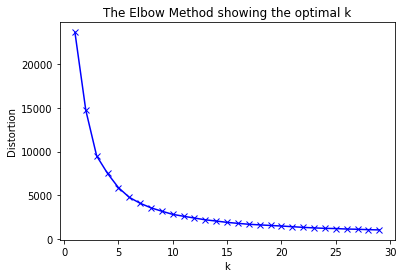

In [4]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

O **k** ótimo apontado pelo _Elbow Method_ está entre 5 e 10, sendo algo em torno de 7.

Apesar do _dataset_ em questão ser para agrupamento de digitos, sendo esperado 10 grupos ao final, o número do **k** ótimo não é 10. Isso pode indicar a semelhança muito alta entre alguns dígitos que acaba aproximando esses elementos e pode dificultar o agrupamento.